<a href="https://colab.research.google.com/github/ejrtks1020/Deep_learning_library/blob/main/_6_3_%EC%BC%80%EB%9D%BC%EC%8A%A4_%EC%A0%84%EC%9D%B4_%ED%95%99%EC%8A%B5_(Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 케라스 전이 학습(Transfer Learning)

<img src="https://miro.medium.com/max/5252/1*Z11P-CjNYWBofEbmGQrptA.png">

<sub>출처: https://medium.com/the-official-integrate-ai-blog/transfer-learning-explained-7d275c1e34e2</sub>


**Transfer learning : 기존의 큰 데이터를 학습시켰던 모델을 가져와서 소규모 데이터를 학습시켜서 사용**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *

In [ ]:
vgg16 = VGG16(weights='imagenet',
            input_shape = (32, 32, 3), include_top = False) 
      #include_top은 모델에 분류기층 포함유무를 설정,
      #include top을 False로 해서 다른 분류기를 사용

**학습되어있는 VGG16모델을 다운로드**

In [ ]:
model = Sequential()
model.add(vgg16)
#------------------------분류기 생성-------------------------------------
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                2570      
Total params: 14,849,610
Trainable params: 14,849,098
Non-trainable params: 512
________________________________________

In [ ]:
mobilenet = MobileNet(weights=None, input_shape=None, include_top=True)

resnet50 = ResNet50(weights=None, input_shape=None, include_top=True)

xception = Xception(weights=None, input_shape=None, include_top=True)

### 예제 : Dogs vs Cats
- Kaggle Data 이용: https://www.kaggle.com/c/dogs-vs-cats/data

- ImageDataGenerator의 flow_from_directory 이용

- 런타임 유형 GPU 사용

- 출처: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb#scrollTo=SdW6geEVi2S8

#### modules import

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Input, Dense, Dropout, MaxPool2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

#### 데이터 로드

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
  /content/cats_and_dogs_filtered.zip

--2021-10-02 18:05:49--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 172.253.120.128, 142.251.5.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   174MB/s    in 0.4s    

2021-10-02 18:05:49 (174 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
local_zip = '/content/cats_and_dogs_filtered.zip' # 예제 압축 데이터 경로
zip_ref = zipfile.ZipFile(local_zip, 'r')   #압축파일를 읽는 객체생성
zip_ref.extractall('/content') #압축 풀기
zip_ref.close()

In [ ]:
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')        #학습데이터 경로지정
validation_dir = os.path.join(base_dir, 'validation') #검증데이터 경로지정

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)  # cat 파일명
train_dog_fnames = os.listdir(train_dogs_dir)  # dog 파일명

#### 이미지 보강된 데이터 확인

In [ ]:
datagen = ImageDataGenerator(
    rotation_range =40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True, #수평 반전
    fill_mode = 'nearest'
)

In [ ]:
img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size = (150, 150))
x= img_to_array(img) #이미지를 배열로 변환

In [ ]:
x.shape

(150, 150, 3)

In [ ]:
x=x.reshape((1,) + x.shape) # 하나의 이미지로 생성하기때문에 새로운 축 추가
x.shape

(1, 150, 150, 3)

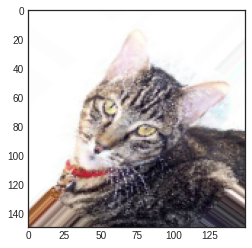

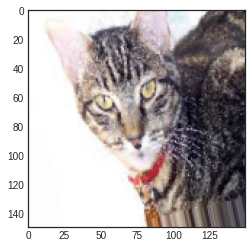

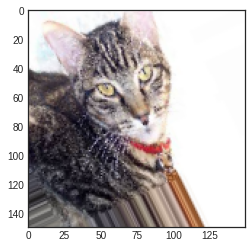

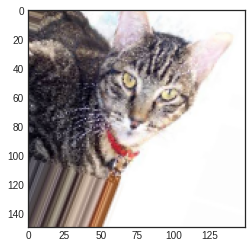

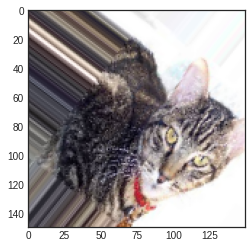

In [ ]:
i = 0    # batch_size가 1이므로 기존 이미지x로부터 1개씩 이미지 배열 생성
for batch in datagen.flow(x, batch_size = 1):  #batch에 이미지 배열을 하나씩 받아온다
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

#### 학습, 검증 데이터셋의 Data Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

val_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size =20,
    class_mode ='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 구성 및 컴파일

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(150, 150, 3)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate = 1e-4),
              metrics = ['acc'])

model.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)      

#### 모델 학습 및 학습 과정 시각화
- 런타임유형 GPU 사용

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch = 100,
                    epochs = 30,
                    batch_size = 256,
                    validation_data = validation_generator,
                    validation_steps = 50,
                    verbose = 2)

Epoch 1/30
100/100 - 21s - loss: 0.6938 - acc: 0.5305 - val_loss: 0.6899 - val_acc: 0.5200
Epoch 2/30
100/100 - 20s - loss: 0.6896 - acc: 0.5335 - val_loss: 0.6953 - val_acc: 0.5030
Epoch 3/30
100/100 - 20s - loss: 0.6854 - acc: 0.5475 - val_loss: 0.6624 - val_acc: 0.6370
Epoch 4/30
100/100 - 20s - loss: 0.6706 - acc: 0.5875 - val_loss: 0.6535 - val_acc: 0.5970
Epoch 5/30
100/100 - 20s - loss: 0.6697 - acc: 0.5955 - val_loss: 0.6221 - val_acc: 0.6670
Epoch 6/30
100/100 - 20s - loss: 0.6413 - acc: 0.6405 - val_loss: 0.6325 - val_acc: 0.6050
Epoch 7/30
100/100 - 20s - loss: 0.6286 - acc: 0.6445 - val_loss: 0.5753 - val_acc: 0.6910
Epoch 8/30
100/100 - 20s - loss: 0.6237 - acc: 0.6530 - val_loss: 0.5493 - val_acc: 0.7200
Epoch 9/30
100/100 - 20s - loss: 0.6080 - acc: 0.6610 - val_loss: 0.6012 - val_acc: 0.6430
Epoch 10/30
100/100 - 20s - loss: 0.6020 - acc: 0.6720 - val_loss: 0.5534 - val_acc: 0.7060
Epoch 11/30
100/100 - 20s - loss: 0.5786 - acc: 0.6925 - val_loss: 0.5368 - val_acc: 0.71

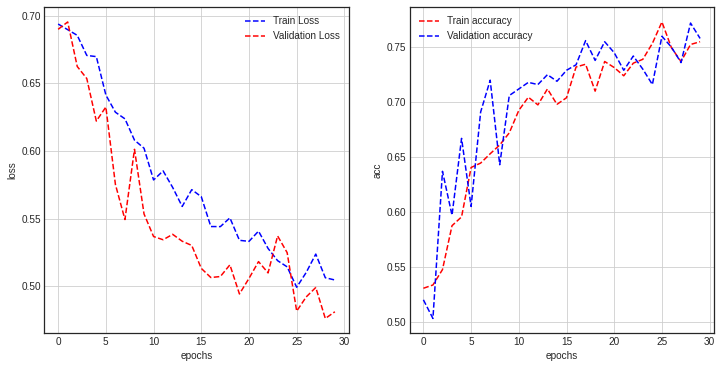

In [ ]:
acc = history.history['acc']
val_acc =history.history['val_acc']
loss = history.history['loss']
val_loss =history.history['val_loss']

plt.figure(figsize=  (12, 6))

epochs = range(len(acc)) # 각 epoch마다 acc가 나오기때문에 총 acc 개수는 전체 epoch의 횟수가 된다.

plt.subplot(1, 2,1)
plt.plot(epochs, loss, 'b--', label = 'Train Loss')
plt.plot(epochs, val_loss, 'r--', label = 'Validation Loss')
plt.grid()
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r--', label = 'Train accuracy')
plt.plot(epochs, val_acc, 'b--', label = 'Validation accuracy')
plt.grid()
plt.legend()
plt.xlabel('epochs')
plt.ylabel('acc')

plt.show()

#### 모델 저장

In [ ]:
model.save('cats_and_dog_model.h5')

### 사전 훈련된 모델 사용

In [ ]:
conv_base = VGG16(weights = 'imagenet',
                  input_shape = (150, 150, 3), include_top = False)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

def build_model_with_pretrained(conv_base):
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(256, activation = 'relu'))
  model.add(Dense(1, activation = 'sigmoid'))

  model.compile(loss = 'binary_crossentropy',
                optimizer = RMSprop(learning_rate = 2e-5),
                metrics = ['accuracy'])

  return model

파라미터의 수 확인!

In [ ]:
model = build_model_with_pretrained(conv_base)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


#### 레이어 동결
- 훈련하기 전, 합성곱 기반 레이어들의(VGG16) 가중치 학습을 막기 위해 이를 동결

In [ ]:
print(len(model.trainable_weights)) #학습가능한 가중치 수 30

30


In [ ]:
conv_base.trainable = False
print(len(model.trainable_weights)) #학습가능한 가중치 수 4개

4


In [ ]:
print(model.trainable_weights)

[<tf.Variable 'dense_10/kernel:0' shape=(8192, 256) dtype=float32, numpy=
array([[ 0.00076676, -0.01894461,  0.01413437, ..., -0.01195221,
         0.00800279, -0.02483273],
       [-0.01923839,  0.02317731, -0.00132566, ...,  0.01990709,
         0.0224299 , -0.00026501],
       [ 0.01676123, -0.01847451,  0.01705988, ...,  0.00557351,
        -0.02552676,  0.02413763],
       ...,
       [ 0.00012622,  0.00941677, -0.0060611 , ...,  0.01160506,
         0.00881468,  0.02651305],
       [-0.0176733 , -0.0231187 ,  0.01104587, ...,  0.0169716 ,
         0.00569229, -0.00057606],
       [-0.00973478, -0.02424741, -0.02395318, ...,  0.00715594,
        -0.02195499, -0.01784962]], dtype=float32)>, <tf.Variable 'dense_10/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

#### 모델 컴파일
- trainable 속성을 변경했기 때문에 다시 모델을 컴파일 해야함

In [ ]:
model.compile(loss = 'binary_crossentropy',              
              optimizer = Adam(learning_rate = 2e-5),
              metrics = ['acc'])

#### 이미지 제너레이터

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

val_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size =20,
    class_mode ='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 재학습

In [ ]:
history2 = model.fit(train_generator,
                    steps_per_epoch = 100,
                    epochs = 30,
                    batch_size = 256,
                    validation_data = validation_generator,
                    validation_steps = 50,
                    verbose = 2)

Epoch 1/30
100/100 - 27s - loss: 0.5914 - acc: 0.6840 - val_loss: 0.4529 - val_acc: 0.8070
Epoch 2/30
100/100 - 26s - loss: 0.4630 - acc: 0.7890 - val_loss: 0.3625 - val_acc: 0.8460
Epoch 3/30
100/100 - 26s - loss: 0.4289 - acc: 0.8065 - val_loss: 0.3346 - val_acc: 0.8620
Epoch 4/30
100/100 - 26s - loss: 0.4031 - acc: 0.8175 - val_loss: 0.3105 - val_acc: 0.8630
Epoch 5/30
100/100 - 26s - loss: 0.3704 - acc: 0.8520 - val_loss: 0.3091 - val_acc: 0.8700
Epoch 6/30
100/100 - 26s - loss: 0.3627 - acc: 0.8425 - val_loss: 0.3013 - val_acc: 0.8730
Epoch 7/30
100/100 - 26s - loss: 0.3497 - acc: 0.8505 - val_loss: 0.2825 - val_acc: 0.8780
Epoch 8/30
100/100 - 26s - loss: 0.3521 - acc: 0.8480 - val_loss: 0.2785 - val_acc: 0.8820
Epoch 9/30
100/100 - 26s - loss: 0.3448 - acc: 0.8485 - val_loss: 0.2786 - val_acc: 0.8810
Epoch 10/30
100/100 - 26s - loss: 0.3246 - acc: 0.8625 - val_loss: 0.2745 - val_acc: 0.8770
Epoch 11/30
100/100 - 26s - loss: 0.3339 - acc: 0.8530 - val_loss: 0.2670 - val_acc: 0.88

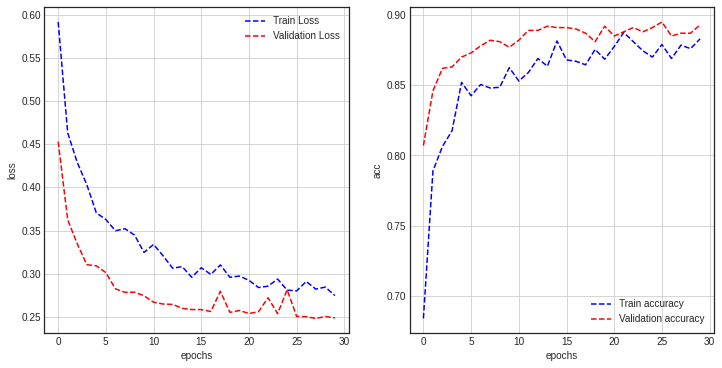

In [ ]:
acc = history2.history['acc']
val_acc =history2.history['val_acc']
loss = history2.history['loss']
val_loss =history2.history['val_loss']

plt.figure(figsize=  (12, 6))

epochs = range(len(acc)) # 각 epoch마다 acc가 나오기때문에 총 acc 개수는 전체 epoch의 횟수가 된다.

plt.subplot(1, 2,1)
plt.plot(epochs, loss, 'b--', label = 'Train Loss')
plt.plot(epochs, val_loss, 'r--', label = 'Validation Loss')
plt.grid()
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'b--', label = 'Train accuracy')
plt.plot(epochs, val_acc, 'r--', label = 'Validation accuracy')
plt.grid()
plt.legend()
plt.xlabel('epochs')
plt.ylabel('acc')

plt.show()

#### 모델 저장

In [ ]:
model.save('cats_and_dogs_with_pretrained_model.h5')

## Feature Map 시각화

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

### 모델 구성

In [ ]:
model = load_model('/content/cats_and_dog_model.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
img_path = '/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg'
img = image.load_img(img_path, target_size = (150, 150))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor[np.newaxis, ...]
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


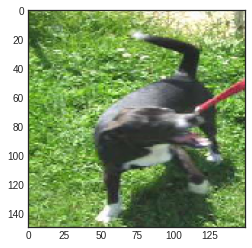

In [ ]:
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
conv_output = [layer.output for layer in model.layers[:8]] # 모델 신경망의 일부 내부 구성 확인
conv_output

[<KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d_12')>,
 <KerasTensor: shape=(None, 74, 74, 32) dtype=float32 (created by layer 'max_pooling2d_4')>,
 <KerasTensor: shape=(None, 72, 72, 64) dtype=float32 (created by layer 'conv2d_13')>,
 <KerasTensor: shape=(None, 36, 36, 64) dtype=float32 (created by layer 'max_pooling2d_5')>,
 <KerasTensor: shape=(None, 34, 34, 128) dtype=float32 (created by layer 'conv2d_14')>,
 <KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'max_pooling2d_6')>,
 <KerasTensor: shape=(None, 15, 15, 128) dtype=float32 (created by layer 'conv2d_15')>,
 <KerasTensor: shape=(None, 7, 7, 128) dtype=float32 (created by layer 'max_pooling2d_7')>]

In [ ]:
activation_model = Model(inputs = [model.input], outputs = conv_output) # input은 모델의 인풋레이어, 아웃풋은 모델의 일부 레이어 사용

In [ ]:
activations = activation_model.predict(img_tensor) # 인풋 이미지가 8종류의 레이어를 통과한 결과 8개를 저장

In [ ]:
len(activations) # 8개의 아웃풋

8

In [ ]:
len(conv_output)

8

### 시각화

(1, 148, 148, 32)


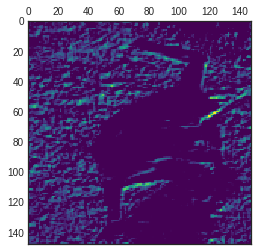

In [ ]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 1], cmap = 'viridis')
plt.show()

(1, 148, 148, 32)


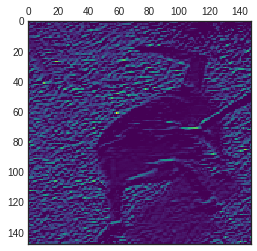

In [ ]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 10], cmap = 'viridis')
plt.show()

(1, 36, 36, 64)


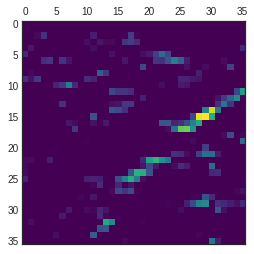

In [ ]:
print(activations[3].shape)
plt.matshow(activations[3][0, :, :, 10], cmap = 'viridis')
plt.show()

### 중간의 모든 활성화에 대해 시각화

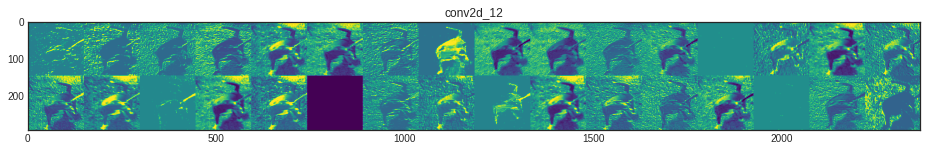

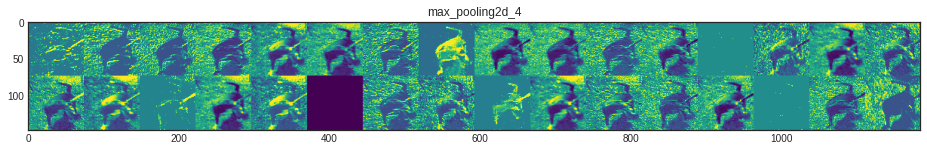

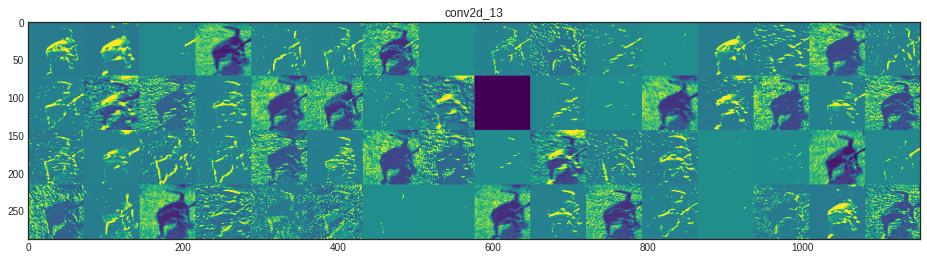

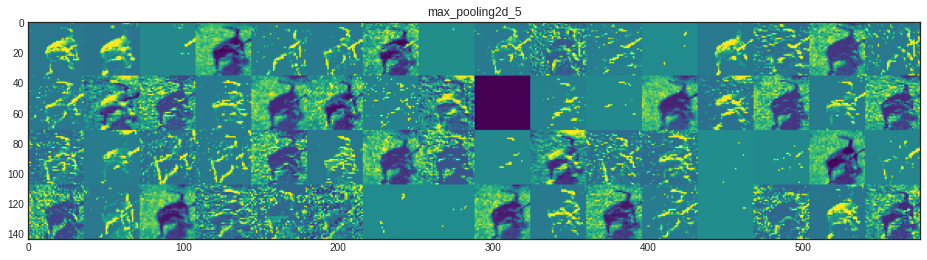

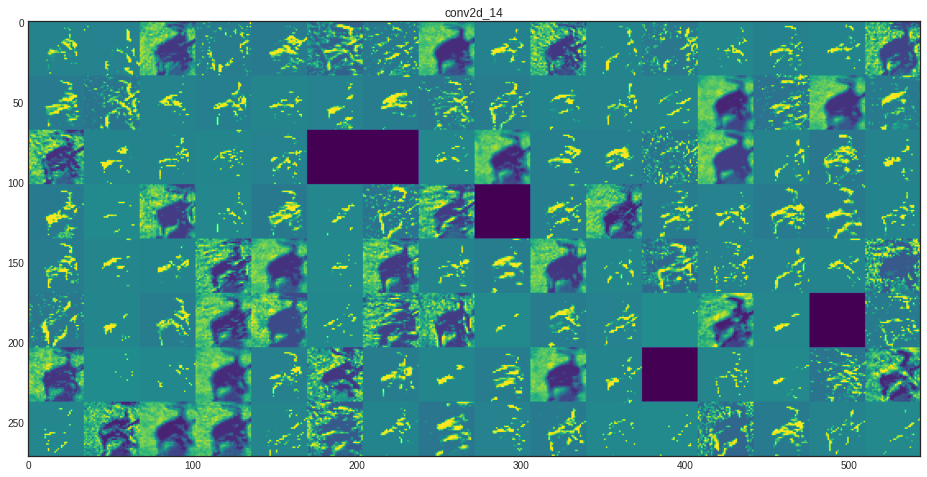

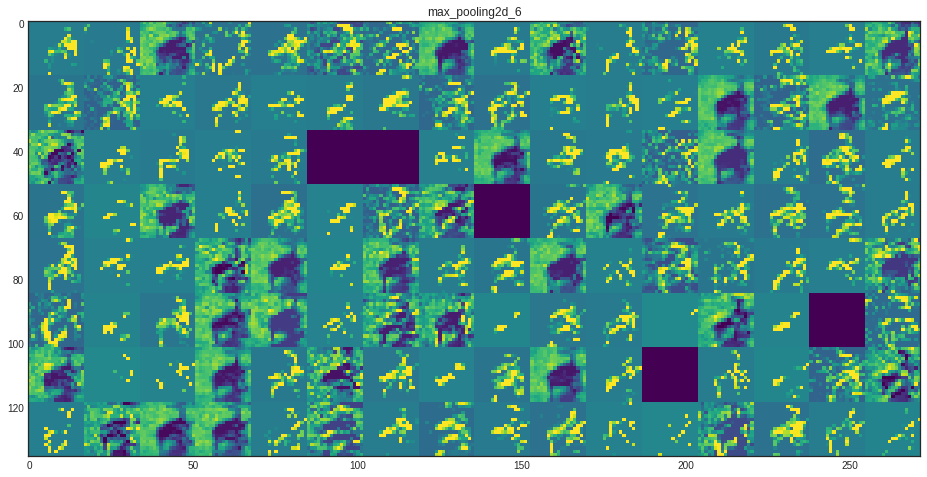

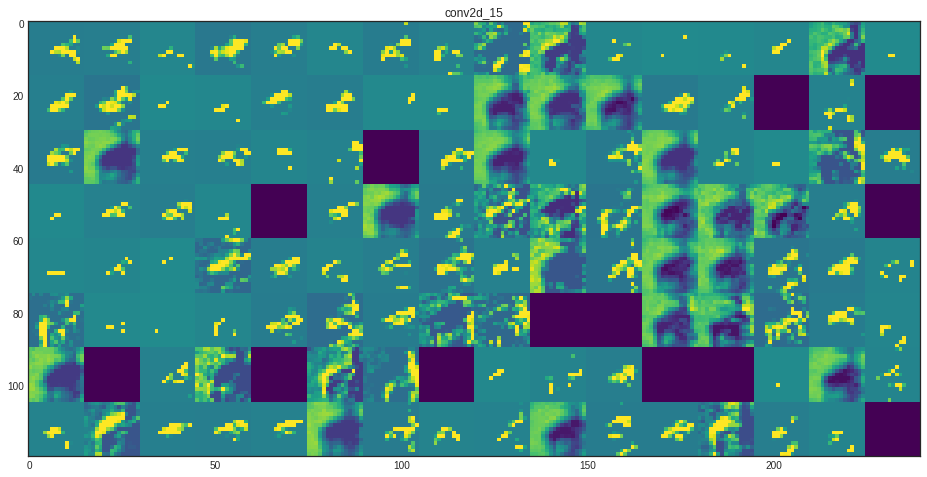

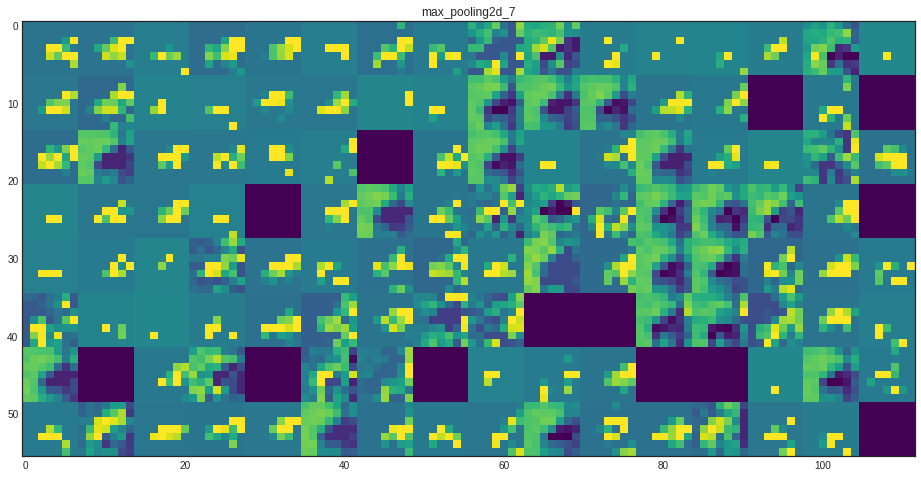

In [ ]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  num_features = layer_activation.shape[-1]

  size = layer_activation.shape[1]

  num_rows = num_features // images_per_row
  display_grid = np.zeros((size * num_rows, size * images_per_row))

  for row in range(num_rows):
    for col in range(images_per_row):
      channel_image = layer_activation[0, :, :, row * images_per_row + col]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8') #0보다 작은값은 0으로, 255보다 큰값은 255로
      display_grid[row * size : (row + 1) * size , col * size : (col + 1) * size] = channel_image

  scale = 1. / size
  
  plt.figure(figsize = (scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
  
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

plt.show()
